# CSE 258 - Rec. Systems & Web Mining - Homework 2


##### Data extraction

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.optimize
import random
from math import exp
from math import log
import time
from random import shuffle

def parseData(fname):
  for l in open(fname):
    yield eval(l)

print("Reading data...")

data = list(parseData("beer.json"))
#shuffle(data)

print("done")

def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

X = np.array([feature(d) for d in data])
Y = np.array([d['beer/ABV'] >= 6.5 for d in data])



Reading data...
done


##### Logistic regression function

In [2]:
def sigmoid(x):
  return 1.0 / (1 + exp(-x))

##################################################
# Logistic regression by gradient ascent         #
##################################################

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  # Array of inner products for X_i, theta
  logits = np.dot(X, theta.T)
  for i in range(len(X)):
    if y[i]:
      loglikelihood -= log(1 + exp(-logits[i]))
    else:
      loglikelihood -= log(1 + exp(-logits[i]))
      loglikelihood -= logits[i]
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  #print loglikelihood
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  # Inner product of X_i, theta
  logits = np.dot(X, theta.T)
  for i in range(len(X)):
    for k in range(len(theta)):
      if y[i]:
        dl[k] += X[i][k] * (1 - sigmoid(logits[i]))
      else:
        dl[k] += X[i][k] * (1 - sigmoid(logits[i]))
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return np.array([-x for x in dl])

def train(lam, X, Y, f, fprime):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X, Y, lam))
  return theta

def predict(X, theta):
    pred = np.dot(X, theta.T)
    assert pred.shape == (len(X),), "Expected shape: {}, but was: {}".format((len(X),), pred.shape)
    return pred > 0

def accuracy(theta, Y, X):
  predictions = predict(X, theta)
  correct = predictions == Y
  acc = sum(correct) * 1.0 / float(len(correct))
  return acc

## Question 1
*The code currently does not perform any train/test splits. Split the data into training, validation, and test sets, via 1/3, 1/3, 1/3 splits. Use the first third, second third, and last third of the data (respectively). After training on the training set, report the accuracy of the classifier on the validation and test sets *

---

### Shuffling the data

I chose to deliver the exercise with the data not shuffled. 
I did get a better accuracy if I shuffled the data.

In [3]:
n = len(X)
X_train, X_test, X_val = (X[0:n/3], X[n/3:2*n/3], X[2*n/3::])
Y_train, Y_test, Y_val = (Y[0:n/3], Y[n/3:2*n/3], Y[2*n/3::])

lam = 1.0
theta = train(lam, X_train, Y_train, f, fprime)
acc_train = accuracy(theta, Y_train, X_train)
acc_test = accuracy(theta, Y_test, X_test)
acc_val = accuracy(theta, Y_val, X_val)

print "Training accuracy: {0:.5f}".format(acc_train)
print "Testing accuracy: {0:.5f}".format(acc_test)
print "Validation accuracy: {0:.5f}".format(acc_val)

Training accuracy: 0.66987
Testing accuracy: 0.90028
Validation accuracy: 0.57779


## Question 2

*Let’s come up with a more accurate classifier1 based on a few common words in the review. Build a feature vector to implement a classifier of the form
$$ p(positive label) = \sigma(\theta_0 + \theta_1 \cdot \#'lactic' + \theta_2 \cdot \#'tart'...) $$
where each feature corresponds to the number of times a particular word appears. Base your feature on the following 10 words: “lactic,” “tart,” “sour,” “citric,” “sweet,” “acid,” “hop,” “fruit,” “salt,” “spicy.”*

---


In [4]:
def count_appearances(text, word):
  return text.lower().count(word.lower())

def feature(d, words):
  feat = [1] + [count_appearances(d['review/text'], word) for word in words]
  return feat

words = ["lactic", "tart", "sour", "citric", "sweet", "acid", "hop", "fruit", "salt", "spicy"]

X = np.array([feature(d, words) for d in data])

In [5]:
n = len(X)
X_train, X_test, X_val = (X[0:n/3], X[n/3:2*n/3], X[2*n/3::])
Y_train, Y_test, Y_val = (Y[0:n/3], Y[n/3:2*n/3], Y[2*n/3::])

lam = 1.0
theta = train(lam, X_train, Y_train, f, fprime)
acc_train = accuracy(theta, Y_train, X_train)
acc_test = accuracy(theta, Y_test, X_test)
acc_val = accuracy(theta, Y_val, X_val)

print "Training accuracy: {0:.5f}".format(acc_train)
print "Testing accuracy: {0:.5f}".format(acc_test)
print "Validation accuracy: {0:.5f}".format(acc_val)

Training accuracy: 0.59018
Testing accuracy: 0.67067
Validation accuracy: 0.53159


## Question 3 

*Report the number of true positives, true negatives, false positives, false negatives, and the Balanced Error Rate of the classifier on the test set (1 mark)*

---


In [6]:
def true_positive(Y, predictions):
  TP = np.sum(np.logical_and(predictions == 1, Y == 1))
  return TP

def true_negative(Y, predictions):
  TN = np.sum(np.logical_and(predictions == 0, Y == 0))
  return TN

def false_positive(Y, predictions):
  FP = np.sum(np.logical_and(predictions == 1, Y == 0))
  return FP

def false_negative(Y, predictions):
  FN = np.sum(np.logical_and(predictions == 0, Y == 1))
  return FN

def balanced_error_rate(Y, predictions): 
  TP = true_positive(Y, predictions)
  FP = false_positive(Y, predictions)
  FN = false_negative(Y, predictions)
  TN = true_negative(Y, predictions)
  TPR = TP / float((TP + FN))
  TNR = TN / float((TN + FP))
  return 1. - 0.5 * (TPR + TNR)


In [7]:
predictions = predict(X_test, theta)
print "True Positive:", true_positive(Y_test, predictions)
print "True Negative:", true_negative(Y_test, predictions)
print "False Positive:", false_positive(Y_test, predictions)
print "False Negative:", false_negative(Y_test, predictions)
print "Balanced Error rate:", balanced_error_rate(Y_test, predictions)

True Positive: 10841
True Negative: 337
False Positive: 421
False Negative: 5068
Balanced Error rate: 0.436985395665


## Question 4 
*Our classifier is possibly less effective than it could be due to the issue of class imbalance (i.e., an uneven number of the datapoints have a positive label). Show how you would adjust the gradient ascent code provided such that the classifier would be approximately ‘balanced’ between the positive and negative classes. Report the Balanced Error Rate (on the train/validation/test sets) for the new classifier*


---
We have our log-likelihood:


$$
L_{\theta}(Y|X) = \frac{n}{2  |y =1|} \sum_{y_i=1} -log(1 + e^{-X_i \cdot \theta}) + \frac{n}{2  |y =0|} \sum_{y_i=0} -log(1 + e^{-X_i \cdot \theta} 
- X_i \cdot \theta + \lambda ||\theta||_2^2
$$

$$
\frac{dL_{\theta}(Y|X)}{d \theta} = \frac{n}{2  |y =1|} \sum_{y=1} X_{ik} (1- \sigma (X_i \theta)) + \frac{n}{2  |y =0|} \sum_{y=0} X_{ik} (1- \sigma (X_i \theta)) - X_{ik} - 2 \lambda \theta_k
$$


We see an improvement of about 2% on the BER. This improvement is more clear if the dataset would be more imbalanced, or if we had shuffled the data.

In [8]:
def get_weight_const(y):
  n = float(len(y))
  y1 = float(np.count_nonzero(y))
  y0 = n - y1
  c1 = n / (y1*2.)
  c0 = n / (y0*2.)
  return c0, c1

# Negative log likelihood
def f(theta, X, y, lam):
  c0, c1 = get_weight_const(y)
  loglikelihood = 0
  # Array of inner products for X_i, theta
  logits = np.dot(X, theta.T)
  for i in range(len(X)):
    if y[i]:
      loglikelihood -= log(1 + exp(-logits[i])) * c1
    else:
      loglikelihood -= log(1 + exp(-logits[i])) * c0
      loglikelihood -= logits[i] * c0
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  #print loglikelihood
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  c0, c1 = get_weight_const(y)
  dl = [0]*len(theta)
  # Inner product of X_i, theta
  logits = np.dot(X, theta.T)
  for i in range(len(X)):
    for k in range(len(theta)):
      if y[i]:
        dl[k] += X[i][k] * (1 - sigmoid(logits[i])) * c1
      else:
        dl[k] += X[i][k] * (1 - sigmoid(logits[i])) * c0
        dl[k] -= X[i][k] * c0
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return np.array([-x for x in dl])

def print_metrics(X, Y, theta):
  predictions  = predict(X, theta)
  print "True Positive:", true_positive(Y, predictions)
  print "True Negative:", true_negative(Y, predictions)
  print "False Positive:", false_positive(Y, predictions)
  print "False Negative:", false_negative(Y, predictions)
  print "Balanced Error rate:", balanced_error_rate(Y, predictions)
  print "Accuracy:", accuracy(theta, Y, X)

In [9]:
n = len(X)
X_train, X_test, X_val = (X[0:n/3], X[n/3:2*n/3], X[2*n/3::])
Y_train, Y_test, Y_val = (Y[0:n/3], Y[n/3:2*n/3], Y[2*n/3::])

lam = 1.0
theta = train(lam, X_train, Y_train, f, fprime)
print "-----\nTraining statistics:"
print_metrics(X_train, Y_train, theta)
print "-----\nTesting statistics:"
print_metrics(X_test, Y_test, theta)
print "-----\nValidation statistics:"
print_metrics(X_val, Y_val, theta)





-----
Training statistics:
True Positive: 4037
True Negative: 5191
False Positive: 2127
False Negative: 5311
Balanced Error rate: 0.429398051101
Accuracy: 0.553702148086
-----
Testing statistics:
True Positive: 6971
True Negative: 559
False Positive: 199
False Negative: 8938
Balanced Error rate: 0.412176667395
Accuracy: 0.451790964181
-----
Validation statistics:
True Positive: 2414
True Negative: 7761
False Positive: 2994
False Negative: 3498
Balanced Error rate: 0.435030045502
Accuracy: 0.610487790244


## Question 5 
*Implement a training/validation/test pipeline so that you can select the best model based on its perfor- mance on the validation set. Try models with *
$$\lambda =  \left(\begin{array}
00 & 0.01 & 0.1 & 1 & 100
\end{array}\right)
$$

*Report the performance on the training/validation/test sets for the best value of λ (1 mark).*

--- 

The choice of the best $\lambda$ is based on the best BER value. There is barely any difference between the $lambda$ values. We see from the graph that the best value is $\lambda = 100$


In [21]:
def get_ber(lam, f, fprime, X, Y):
  n = len(X)
  X_train, X_test, X_val = (X[0:n/3], X[n/3:2*n/3], X[2*n/3::])
  Y_train, Y_test, Y_val = (Y[0:n/3], Y[n/3:2*n/3], Y[2*n/3::])
  
  # Find theta on training data
  theta = train(lam, X_train, Y_train, f, fprime)
  # Tune the lambda with validation set
  predictions = predict(X_val, theta)
  # Tune the lambda with validation set
  ber = balanced_error_rate(Y_val, predictions)
  print "lam={} \t ber={}".format(lam, ber)
  return ber

lams = [0, 0.01, 0.1, 1, 100,1000]
bers = []
for lam in lams:
  b = get_ber(lam, f, fprime, X, Y)
  bers.append(b)


lam=0 	 ber=0.436919016488
lam=0.01 	 ber=0.436919016488
lam=0.1 	 ber=0.436919016488
lam=1 	 ber=0.43683444274
lam=100 	 ber=0.439110408414
lam=1000 	 ber=0.441205611954


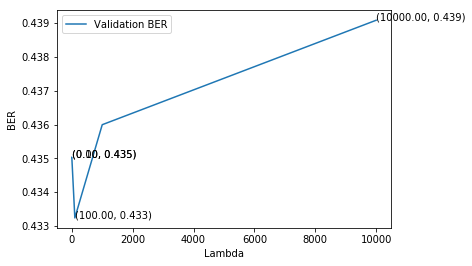

In [20]:
for xy in zip(lams, bers)[:]:                                       # <--
  plt.annotate('(%.2f, %.3f)' % xy, xy=xy, textcoords='data') # <--
plt.plot(lams, bers, label="Validation BER")
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('BER')
plt.show()

In [12]:
lam = 100
theta = train(lam, X_train, Y_train, f, fprime)
print "-----\nTraining statistics:"
print_metrics(X_train, Y_train, theta)
print "-----\nTesting statistics:"
print_metrics(X_test, Y_test, theta)
print "-----\nValidation statistics:"
print_metrics(X_val, Y_val, theta)



-----
Training statistics:
True Positive: 4028
True Negative: 5191
False Positive: 2127
False Negative: 5320
Balanced Error rate: 0.429879437493
Accuracy: 0.553162126485
-----
Testing statistics:
True Positive: 6951
True Negative: 559
False Positive: 199
False Negative: 8958
Balanced Error rate: 0.412805242415
Accuracy: 0.45059098818
-----
Validation statistics:
True Positive: 2422
True Negative: 7785
False Positive: 2970
False Negative: 3490
Balanced Error rate: 0.433237695404
Accuracy: 0.612407751845


# Dimensionality Reduction

## Question 6

*Find and report the PCA components (i.e., the transform matrix) using the week 3 code (1 mark).*

---



In [13]:
from sklearn.decomposition import PCA

def feature(d, words):
  feat = [count_appearances(d['review/text'], word) for word in words]
  return feat

X = np.array([feature(d, words) for d in data])
n = len(X)
X_train, X_test, X_val = (X[0:n/3], X[n/3:2*n/3], X[2*n/3::])
Y_train, Y_test, Y_val = (Y[0:n/3], Y[n/3:2*n/3], Y[2*n/3::])

pca = PCA(n_components=10)
pca.fit(X_train)
assert pca.components_.shape == (10,10)
print "PCA Components:\n", pca.components_

PCA Components:
[[ -9.45257253e-04   1.16974959e-02  -1.19664614e-02   1.33419235e-02
    1.05120403e-01   1.79457226e-03   9.84741210e-01   1.35598399e-01
    4.59479736e-04   1.96255971e-02]
 [  2.46324777e-03   4.44171070e-02   9.50488366e-03   6.73602998e-04
    9.71555003e-01   4.10505891e-03  -1.30790119e-01   1.91579045e-01
    1.50095154e-03   1.35440738e-02]
 [  3.12946664e-03   4.73537038e-02   3.91534945e-02   4.54565212e-03
   -2.09090111e-01   7.94925530e-03  -1.11771416e-01   9.69193701e-01
    4.66470642e-03   2.36911504e-02]
 [  2.44184954e-02   8.52307858e-01   5.11850323e-01   1.05866679e-02
   -3.00524596e-02   6.13076186e-02   7.91979830e-03  -6.94293166e-02
    7.88854563e-03   3.55677425e-02]
 [  1.48663270e-02  -5.14637213e-01   8.54122237e-01  -6.91810409e-04
    1.82955353e-02   4.94690178e-02   1.58337230e-02  -2.85756422e-03
    1.48501252e-03  -4.85723030e-02]
 [ -1.28725003e-03  -5.75843509e-02   2.25235922e-02   1.99339209e-02
   -8.34344105e-03  -2.008524

## Question 7
*Suppose we want to compress the data using just two PCA dimensions. How large is the reconstruction
error when doing so (1 mark)?*

---


The reconstruction error is given by
$$ 
\frac{1}{N} \sum_y \sum_{j=k+1}^M (y_j - \bar{y_j})^2
$$
This is also the same as the variance of the discarded dimensions


#### Found from taking the mean-squared error directly

In [14]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)
X_reconstructed = pca.inverse_transform(X_pca)
((X_train - X_reconstructed) **2).mean()

0.12228045087666031

#### Found from taking the variance of the discarded dimensions

In [15]:
pca10 = PCA(n_components=10)
pca10.fit(X_train)
xpca = pca10.transform(X_train)
var = np.var(xpca, axis=0)
sum(var[2::]) / 10

0.12228045087665665

## Question 8 
*Looking at the first two dimensions of our data in the PCA basis is an effective way to ‘summarize’ the data via a 2-d plot. Using a plotting program of your choice, make a 2-d scatterplot showing the difference between ‘American IPA’ style beers versus all other styles (e.g. plot American IPAs in red and other styles in blue) *

---

(16666, 2)


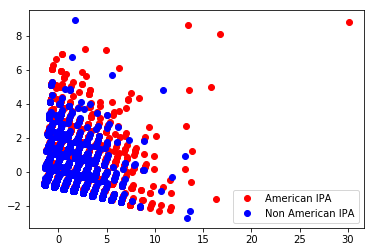

In [16]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)
tmask = np.where(Y_train==1)[0]
fmask = np.where(Y_train==0)[0]

print X_pca.shape
Xt = X_pca[tmask]
Xf = X_pca[fmask]

plt.plot(Xt[:,0], Xt[:,1], 'ro', label='American IPA')
plt.plot(Xf[:,0], Xf[:,1], 'bo', label='Non American IPA')
#plt.plot(X_pca[tlabel], 'ro', label='American IPA')
plt.legend()
plt.show()